In [1]:
import os
import keras

In [2]:
import matplotlib.pyplot as plt
import numpy as np
import seaborn as sns
import tensorflow as tf
import librosa
import librosa.display
import re
from sklearn.model_selection import train_test_split

In [3]:
ds_dir = '/arch/mnist_data'
filenames = []

for root, dirs, files in os.walk(ds_dir):
    for file in files:
        filenames.append(os.path.join(root,file))
filenames = [re.sub(r'(\\)', '/', name) for name in filenames[1:]]

samples_number = len(filenames)
print('Total number of samples:', samples_number)

Total number of samples: 30000


In [4]:
labels = np.array(["0","1","2","3","4","5","6","7","8","9"])
train_files,test_files = train_test_split(filenames, test_size=0.3, shuffle=True)
test_files,val_files = train_test_split(test_files, test_size=0.33, shuffle=True)

print('Training data size', len(train_files))
print('Test data size', len(test_files))
print('Validation data size', len(val_files))

Training data size 21000
Test data size 6030
Validation data size 2970


In [5]:
def get_label(file_path):
    label = re.findall(r'/([0-9])_', file_path)[0]
    index = np.argmax(label == labels)
    label_id = np.zeros(len(labels))
    label_id[index] = 1
    return label_id

In [6]:
input_shape = (128,44)
def get_ms(file_path):
    y, sr = librosa.load(file_path)
    ms = librosa.feature.melspectrogram(y=y, sr=sr,n_fft=2048, hop_length=512)
    ms = np.resize(ms, input_shape)
    
    ms = np.log(ms + 1e-9)
    ms = librosa.util.normalize(ms)
    
    ms = np.repeat(ms[..., np.newaxis], 3, -1)
    return ms

In [7]:
def preprocess_dataset(files):
    output_labels = np.array([get_label(file) for file in files])
    output_ms = np.array([get_ms(file) for file in files])
    return output_ms, output_labels

In [15]:
train_ms,train_labels = preprocess_dataset(train_files)
test_ms,test_labels = preprocess_dataset(test_files)
val_ms,val_labels = preprocess_dataset(val_files)

In [16]:
tf.compat.v1.enable_eager_execution()

In [17]:
train_dataset = tf.data.Dataset.from_tensor_slices((train_ms, train_labels))
test_dataset = tf.data.Dataset.from_tensor_slices((test_ms, test_labels))
val_dataset = tf.data.Dataset.from_tensor_slices((val_ms, val_labels))

In [133]:
batch_size = 64
train_batches = train_dataset.batch(batch_size)
test_batches = test_dataset.batch(batch_size)
val_batches = val_dataset.batch(batch_size)

# Evaluation

In [152]:
import sklearn
def metric_calc(model):
    y_true=test_labels
    y_pred = model.predict(test_batches, verbose=2)
    
    y_pred = np.array([np.argmax(i) for i in y_pred])   
    y_true = np.array([np.argmax(i) for i in y_true])
    
    accuracy = sklearn.metrics.accuracy_score(y_true, y_pred)
    precision = sklearn.metrics.precision_score(y_true, y_pred, average='weighted', zero_division=0)
    recall = sklearn.metrics.recall_score(y_true, y_pred, average='weighted', zero_division=0)
    f1 = sklearn.metrics.f1_score(y_true, y_pred, average='weighted', zero_division=0)
    return accuracy, precision, recall, f1

In [157]:
from keras.models import load_model
model = load_model("models/mobilenet_no_weights", custom_objects = {"f1_score":f1_score, "precision":precision, 
                                                                      "recall":recall})

In [161]:
model.compile(optimizer=tf.keras.optimizers.SGD(learning_rate=1e-2, momentum=0.9, decay=1e-2/epoch),
              loss=keras.losses.CategoricalCrossentropy(from_logits=True),
              metrics=['accuracy', f1_score, precision1, recall])
# accuracy auc recall оставить ток

In [162]:
model.evaluate(test_batches, verbose=2)

95/95 - 12s - loss: 0.0274 - accuracy: 0.9910 - f1_score: 0.4674 - precision1: 0.3050 - recall: 1.0000 - 12s/epoch - 123ms/step


[0.02738754078745842,
 0.9910447597503662,
 0.46736574172973633,
 0.30503153800964355,
 1.0]

In [153]:
metric_calc(model)

95/95 - 10s - 10s/epoch - 105ms/step


ValueError: multiclass format is not supported

# RegNetY006

In [12]:
epoch=15

In [160]:
from keras import backend as K

def recall(y_true, y_pred):
    true_positives = K.sum(K.round(K.clip(y_true * y_pred, 0, 1)))
    possible_positives = K.sum(K.round(K.clip(y_true, 0, 1)))
    recall = true_positives / (possible_positives + K.epsilon())
    return recall

def precision1(y_true, y_pred):
    true_positives = K.sum(K.round(K.clip(y_true * y_pred, 0, 1)))
    predicted_positives = K.sum(K.round(K.clip(y_pred, 0, 1)))
    precision = true_positives / (predicted_positives + K.epsilon())
    return precision

def f1_score(y_true, y_pred):
    prec = precision1(y_true, y_pred)
    rec = recall(y_true, y_pred)
    return 2*((prec*rec)/(prec+rec+K.epsilon()))

In [20]:
model_regnety006 = tf.keras.applications.regnet.RegNetX002(input_shape=input_shape+(3,), include_top=False, 
                                               include_preprocessing=False, weights=None)

regnety006 = keras.Sequential([
    model_regnety006,
    keras.layers.GlobalAveragePooling2D(),
    keras.layers.Dropout(0.2),
    keras.layers.Dense(10)                
])

regnety006.compile(optimizer=tf.keras.optimizers.SGD(learning_rate=1e-2, momentum=0.9, decay=1e-2/epoch),
              loss=keras.losses.CategoricalCrossentropy(from_logits=True),
              metrics=['accuracy', f1_score, precision, recall])

history_regnety006 = regnety006.fit(train_batches,
                    epochs=epoch,
                    validation_data=val_batches, 
                    verbose=1,
                    shuffle=True)

Epoch 1/15
133/329 [===========>..................] - ETA: 18:21 - loss: 2.9263 - accuracy: 0.2558 - f1_score: 0.2512 - precision: 0.1559 - recall: 0.6523

KeyboardInterrupt: 

In [26]:
test_loss, test_acc, test_f1, test_prec, test_rec = regnety006.evaluate(test_batches, verbose=2)

1/1 - 0s - loss: 4191.4751 - accuracy: 0.1000 - f1_score: 0.0667 - precision: 0.0500 - recall: 0.1000 - 86ms/epoch - 86ms/step


In [28]:
regnety006.save("models/test")
# tf.keras.models.load_model('models/my_model')

INFO:tensorflow:Assets written to: models/test\assets


INFO:tensorflow:Assets written to: models/test\assets


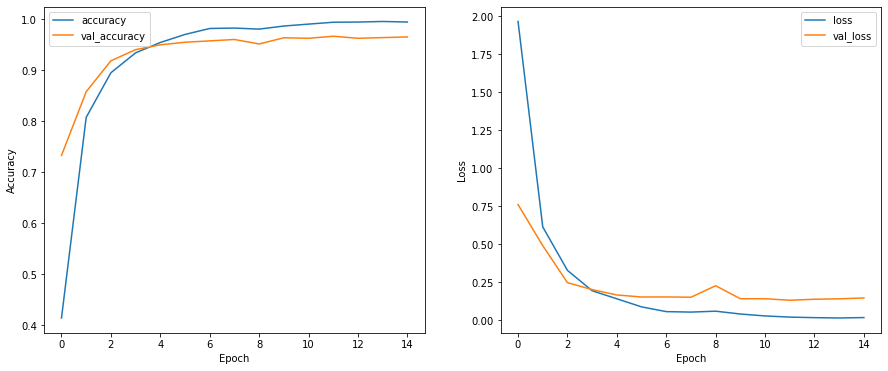

In [17]:
fig, [ax1, ax2] = plt.subplots(1, 2, figsize=(15, 6))

ax1.plot(history_regnety006.history['accuracy'], label='accuracy')
ax1.plot(history_regnety006.history['val_accuracy'], label = 'val_accuracy')
ax1.set_xlabel('Epoch')
ax1.set_ylabel('Accuracy')
ax1.legend()

ax2.plot(history_regnety006.history['loss'], label='loss')
ax2.plot(history_regnety006.history['val_loss'], label='val_loss')
ax2.set_xlabel('Epoch')
ax2.set_ylabel('Loss')
ax2.legend()

plt.show()